In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
import os
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications import VGG16
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix
from PIL import Image
from IPython.display import display, clear_output
import ipywidgets as widgets
import io
from keras import layers
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, Activation,Concatenate, BatchNormalization

In [ ]:
labels = ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']
X_train = []
y_train = []
X_test = []
y_test = []
image_size = 224
for i in labels:
    folderPath = os.path.join('../content/drive/MyDrive/new first objective dataset/Training', i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size, image_size))
        X_train.append(img)
        y_train.append(i)

for i in labels:
    folderPath = os.path.join('../content/drive/MyDrive/new first objective dataset/Testing', i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size,image_size))
        X_test.append(img)
        y_test.append(i)

X_train = np.array(X_train)
y_train = np.array(y_train)

X_test = np.array(X_test)
y_test = np.array(y_test)

100%|██████████| 58/58 [00:36<00:00,  1.60it/s]


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


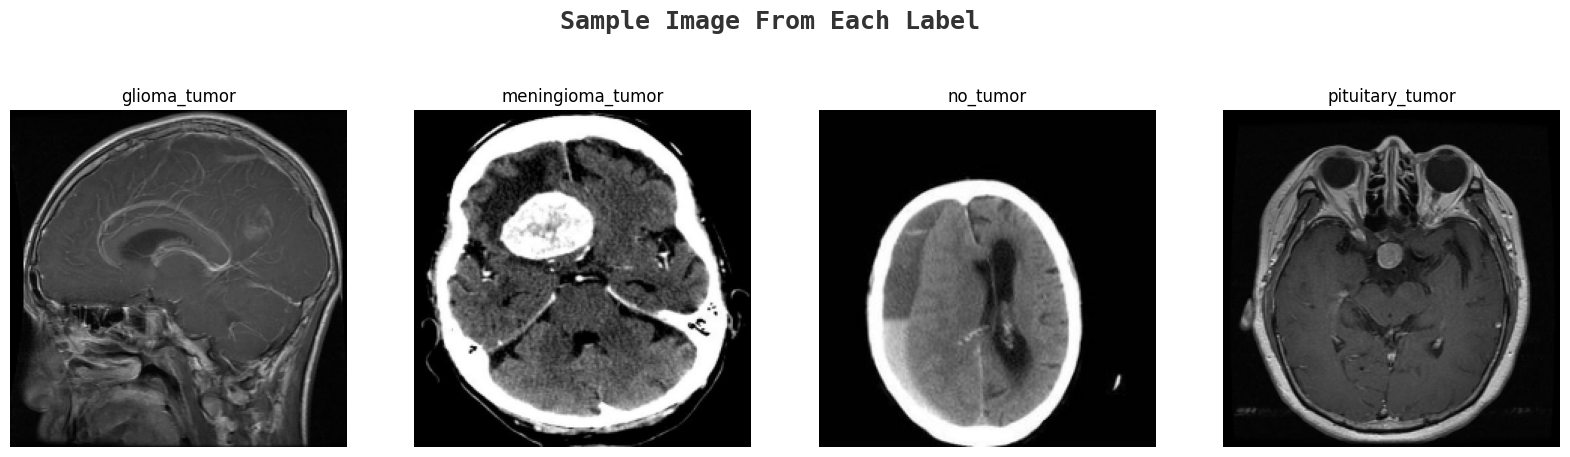

In [ ]:
k=0
fig, ax = plt.subplots(1,4,figsize=(20,20))
fig.text(s='Sample Image From Each Label',size=18,fontweight='bold',
             fontname='monospace',y=0.62,x=0.4,alpha=0.8)
for i in labels:
    j=0
    while True :
        if y_train[j]==i:
            ax[k].imshow(X_train[j])
            ax[k].set_title(y_train[j])
            ax[k].axis('off')
            k+=1
            break
        j+=1

In [ ]:
X_train, y_train = shuffle(X_train,y_train, random_state=14)

In [ ]:
X_train.shape

(974, 224, 224, 3)

In [ ]:
X_test.shape

(338, 224, 224, 3)

<Axes: ylabel='count'>

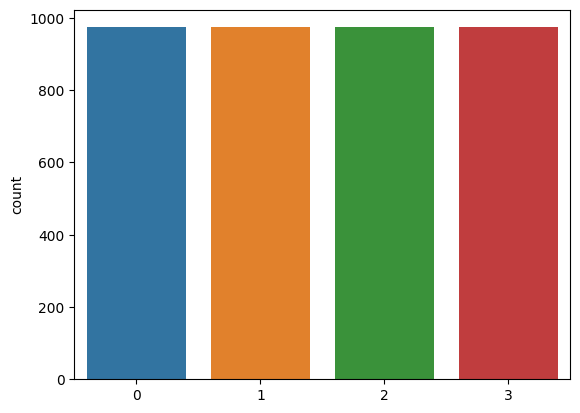

In [ ]:
sns.countplot(y_train)

<Axes: ylabel='count'>

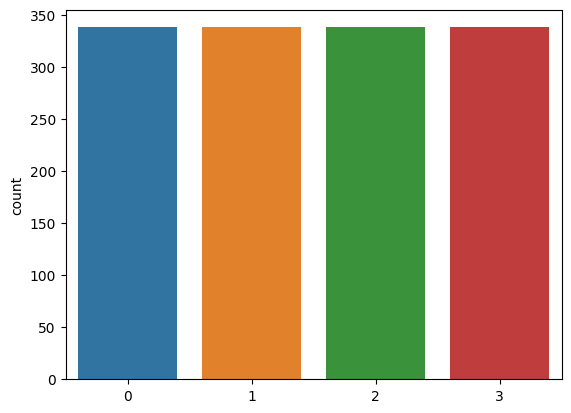

In [ ]:
sns.countplot(y_test)

In [ ]:
y_train_new = []
for i in y_train:
    y_train_new.append(labels.index(i))
y_train = y_train_new
y_train = tf.keras.utils.to_categorical(y_train)


y_test_new = []
for i in y_test:
    y_test_new.append(labels.index(i))
y_test = y_test_new
y_test = tf.keras.utils.to_categorical(y_test)

In [ ]:
X_train,X_val,y_train,y_val = train_test_split(X_train,y_train, test_size=0.1,random_state=14)

In [ ]:
X_train = np.array(X_train) / 255.
X_val = np.array(X_val) / 255.
X_test = np.array(X_test) / 255.

In [ ]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range=0.1,  # Randomly zoom image
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images

datagen.fit(X_train)

In [ ]:
tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint("effnet.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 2, min_delta = 0.001,
                              mode='auto',verbose=1)

In [ ]:
model_cnn = Sequential()

model_cnn.add(Conv2D(128, (5, 5), padding='same',input_shape=(image_size,image_size,3)))
model_cnn.add(Activation('relu'))
#model_cnn.add(BatchNormalization())

model_cnn.add(Conv2D(64, (3, 3), padding='same',input_shape=(image_size,image_size,3)))
model_cnn.add(Activation('relu'))

model_cnn.add(Conv2D(128, (3, 3)))
model_cnn.add(Activation('relu'))
model_cnn.add(MaxPooling2D(pool_size=(2, 2)))
#model_cnn.add(BatchNormalization())
#model_cnn.add(Dropout(0.35))

model_cnn.add(Conv2D(128, (3, 3), padding='same'))
model_cnn.add(Activation('relu'))
model_cnn.add(BatchNormalization())

model_cnn.add(Conv2D(64, (3, 3)))
model_cnn.add(Activation('relu'))
model_cnn.add(MaxPooling2D(pool_size=(2, 2)))
#model_cnn.add(BatchNormalization())
#model_cnn.add(Dropout(0.35))

model_cnn.add(Conv2D(64, (3, 3)))
model_cnn.add(Activation('relu'))
model_cnn.add(MaxPooling2D(pool_size=(2, 2)))

model_cnn.add(Conv2D(64, (3, 3), padding='same'))
model_cnn.add(Activation('relu'))
model_cnn.add(BatchNormalization())

model_cnn.add(Flatten())
model_cnn.add(Dropout(0.5))
model_cnn.add(Dense(512))
model_cnn.add(Activation('relu'))
#model_cnn.add(BatchNormalization())
model_cnn.add(Dense(4))
model_cnn.add(Activation('softmax'))

model_cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 128)     9728      
                                                                 
 activation (Activation)     (None, 224, 224, 128)     0         
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 64)      73792     
                                                                 
 activation_1 (Activation)   (None, 224, 224, 64)      0         
                                                                 
 conv2d_2 (Conv2D)           (None, 222, 222, 128)     73856     
                                                                 
 activation_2 (Activation)   (None, 222, 222, 128)     0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 128)    0

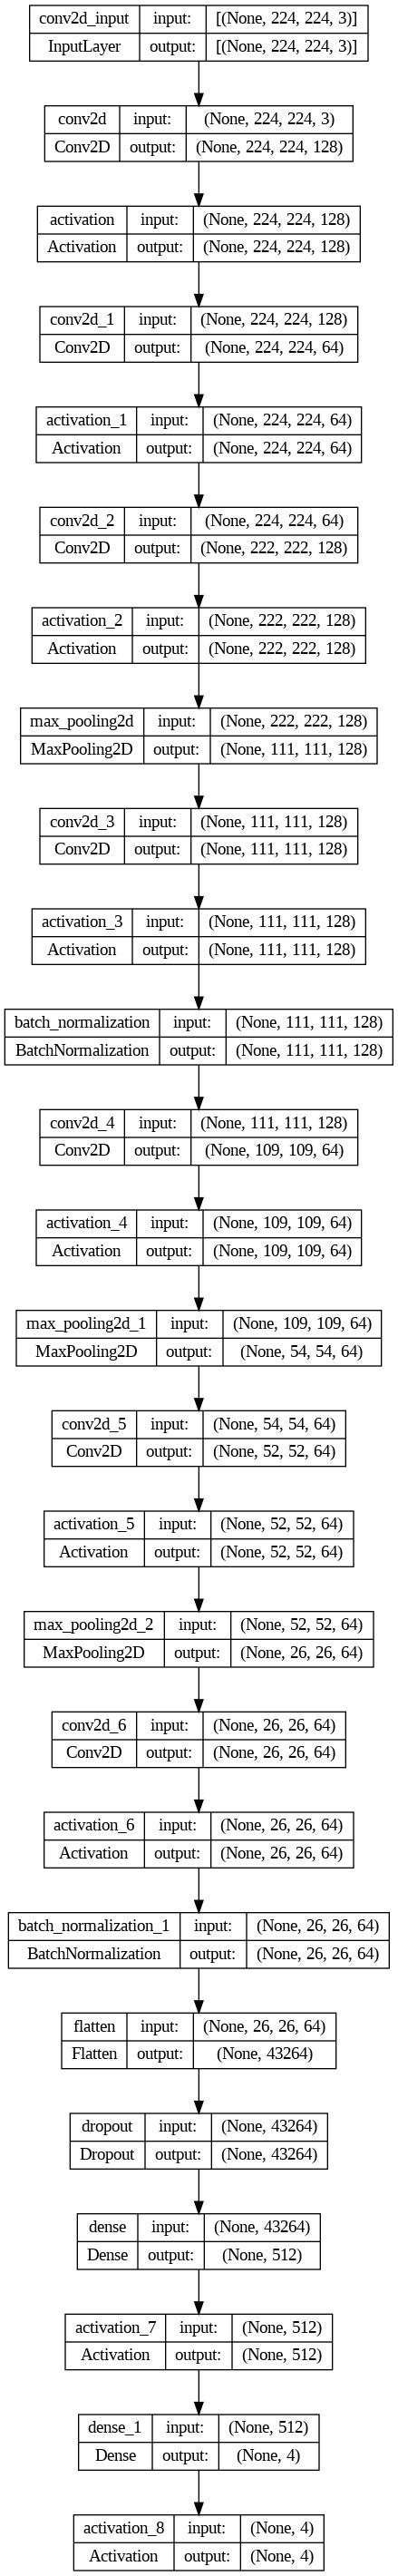

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model_cnn, to_file='model_cnn_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
model_cnn.compile(optimizer = 'adam',
               loss = 'categorical_crossentropy',
               metrics = ['accuracy'])

In [ ]:
history = model_cnn.fit(X_train, y_train,validation_split=0.2, verbose=1, batch_size = 64, validation_data = (X_val, y_val),
                     epochs = 15)
                #callbacks =[tensorboard,checkpoint,reduce_lr])

Epoch 1/15
14/14 [==============================] - 78s 3s/step - loss: 5.3168 - accuracy: 0.5377 - val_loss: 15.5494 - val_accuracy: 0.3878
Epoch 2/15
14/14 [==============================] - 15s 1s/step - loss: 0.6005 - accuracy: 0.7820 - val_loss: 20.4902 - val_accuracy: 0.3878
Epoch 3/15
14/14 [==============================] - 15s 1s/step - loss: 0.3233 - accuracy: 0.8893 - val_loss: 16.0410 - val_accuracy: 0.3776
Epoch 4/15
14/14 [==============================] - 15s 1s/step - loss: 0.1914 - accuracy: 0.9429 - val_loss: 15.7536 - val_accuracy: 0.3776
Epoch 5/15
14/14 [==============================] - 15s 1s/step - loss: 0.1049 - accuracy: 0.9715 - val_loss: 9.4962 - val_accuracy: 0.3980
Epoch 6/15
14/14 [==============================] - 15s 1s/step - loss: 0.0687 - accuracy: 0.9817 - val_loss: 10.9745 - val_accuracy: 0.3878
Epoch 7/15
14/14 [==============================] - 15s 1s/step - loss: 0.0324 - accuracy: 0.9886 - val_loss: 5.9644 - val_accuracy: 0.4184
Epoch 8/15
14/1

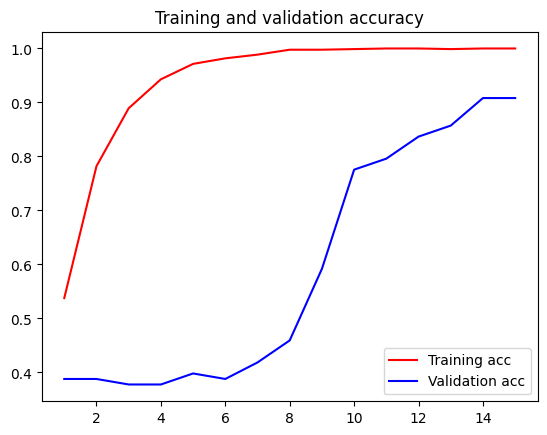

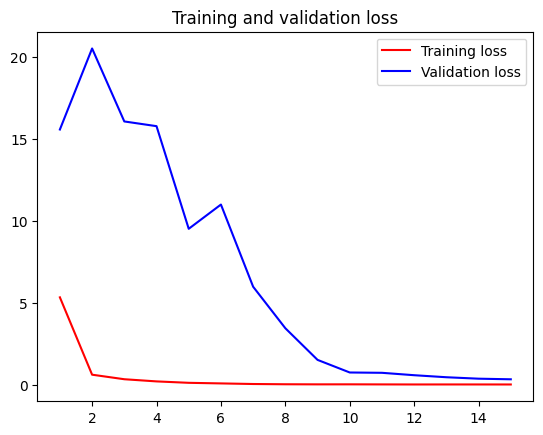

In [ ]:
model_cnn.save('cnn_model.h5')

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
pred = model_cnn.predict(X_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)

11/11 [==============================] - 11s 485ms/step


In [ ]:
accuracy = np.sum(pred==y_test_new)/len(pred)
print("Accuracy on testing dataset: {:.2f}%".format(accuracy*100))

Accuracy on testing dataset: 71.89%


In [ ]:
model_cnn.evaluate(X_train, y_train)

28/28 [==============================] - 6s 213ms/step - loss: 0.0240 - accuracy: 0.9989


[0.02396732196211815, 0.9988584518432617]

In [ ]:
print(classification_report(y_test_new,pred))

              precision    recall  f1-score   support

           0       0.78      0.19      0.30        75
           1       0.71      0.94      0.81       100
           2       0.68      0.99      0.81       105
           3       0.89      0.53      0.67        58

    accuracy                           0.72       338
   macro avg       0.76      0.66      0.65       338
weighted avg       0.75      0.72      0.67       338



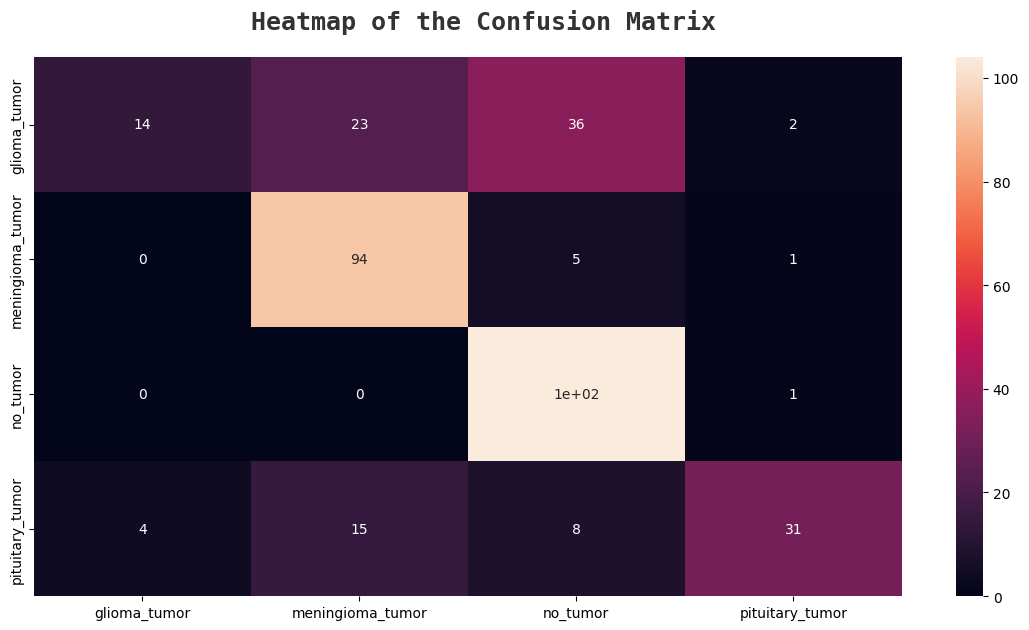

In [ ]:
fig,ax=plt.subplots(1,1,figsize=(14,7))
sns.heatmap(confusion_matrix(y_test_new,pred),ax=ax,xticklabels=labels,yticklabels=labels,annot=True)
fig.text(s='Heatmap of the Confusion Matrix',size=18,fontweight='bold',
             fontname='monospace',y=0.92,x=0.28,alpha=0.8)

plt.show()

In [ ]:
VGG16

In [ ]:
vgg=VGG16(input_shape=(image_size,image_size,3) , weights='imagenet' , include_top=False)

58889256/58889256 [==============================] - 4s 0us/step


In [ ]:
for layers in vgg.layers:
  layers.trainable=False

In [ ]:
model_vgg = vgg.output
model_vgg = GlobalAveragePooling2D()(model_vgg)
model_vgg = Dense(128,activation='relu')(model_vgg)
model_vgg = Dropout(0.15)(model_vgg)
model_vgg = Dense(4,activation='softmax')(model_vgg)
model_vgg = Model(inputs=vgg.input,outputs=model_vgg)
model_vgg.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

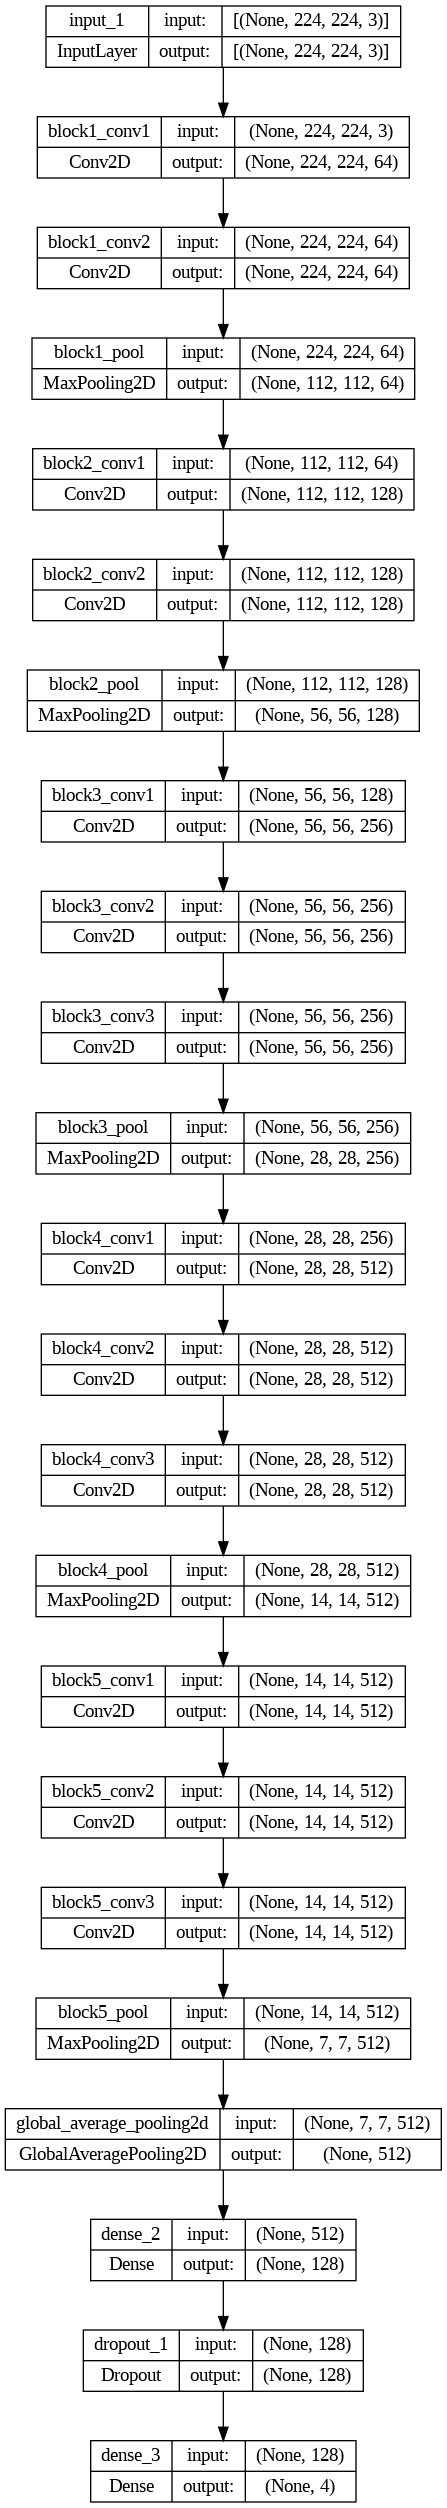

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model_vgg, to_file='model_vgg_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
model_vgg.compile(optimizer = 'adam',
               loss = 'categorical_crossentropy',
               metrics = ['accuracy'])

In [ ]:
history = model_vgg.fit(X_train, y_train,validation_split=0.2, verbose=1, batch_size = 32, validation_data = (X_val, y_val),
                     epochs = 15)
                  #callbacks =[tensorboard,checkpoint,reduce_lr])

Epoch 1/15
28/28 [==============================] - 14s 278ms/step - loss: 1.3083 - accuracy: 0.3676 - val_loss: 1.1150 - val_accuracy: 0.6224
Epoch 2/15
28/28 [==============================] - 5s 162ms/step - loss: 1.0783 - accuracy: 0.6199 - val_loss: 0.9617 - val_accuracy: 0.6939
Epoch 3/15
28/28 [==============================] - 4s 157ms/step - loss: 0.9143 - accuracy: 0.7226 - val_loss: 0.8565 - val_accuracy: 0.7857
Epoch 4/15
28/28 [==============================] - 4s 157ms/step - loss: 0.8044 - accuracy: 0.7648 - val_loss: 0.7694 - val_accuracy: 0.8061
Epoch 5/15
28/28 [==============================] - 4s 156ms/step - loss: 0.7326 - accuracy: 0.7660 - val_loss: 0.6751 - val_accuracy: 0.8469
Epoch 6/15
28/28 [==============================] - 5s 166ms/step - loss: 0.6564 - accuracy: 0.7934 - val_loss: 0.6345 - val_accuracy: 0.8367
Epoch 7/15
28/28 [==============================] - 4s 161ms/step - loss: 0.6062 - accuracy: 0.7888 - val_loss: 0.6210 - val_accuracy: 0.8061
Epoch

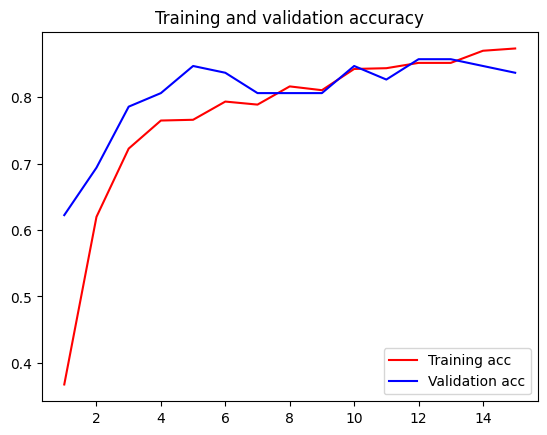

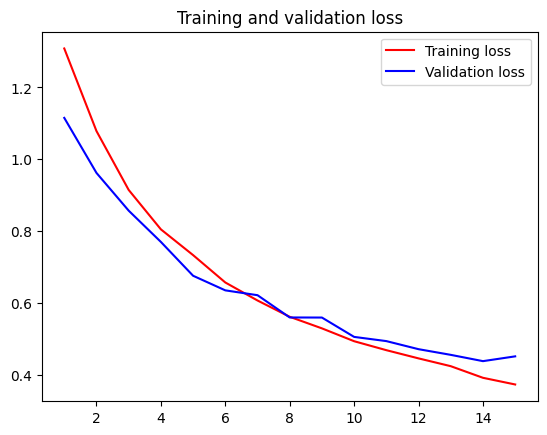

In [ ]:
model_vgg.save('vgg16_model.h5')


acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
pred = model_vgg.predict(X_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)

11/11 [==============================] - 5s 436ms/step


In [ ]:
accuracy = np.sum(pred==y_test_new)/len(pred)
print("Accuracy on testing dataset: {:.2f}%".format(accuracy*100))

Accuracy on testing dataset: 62.13%


In [ ]:
model_vgg.evaluate(X_train, y_train)

28/28 [==============================] - 4s 132ms/step - loss: 0.3426 - accuracy: 0.8950


[0.34262850880622864, 0.8949771523475647]

In [ ]:
print(classification_report(y_test_new,pred))

              precision    recall  f1-score   support

           0       0.70      0.19      0.29        75
           1       0.58      0.67      0.62       100
           2       0.58      0.87      0.70       105
           3       0.81      0.66      0.72        58

    accuracy                           0.62       338
   macro avg       0.67      0.59      0.58       338
weighted avg       0.65      0.62      0.59       338



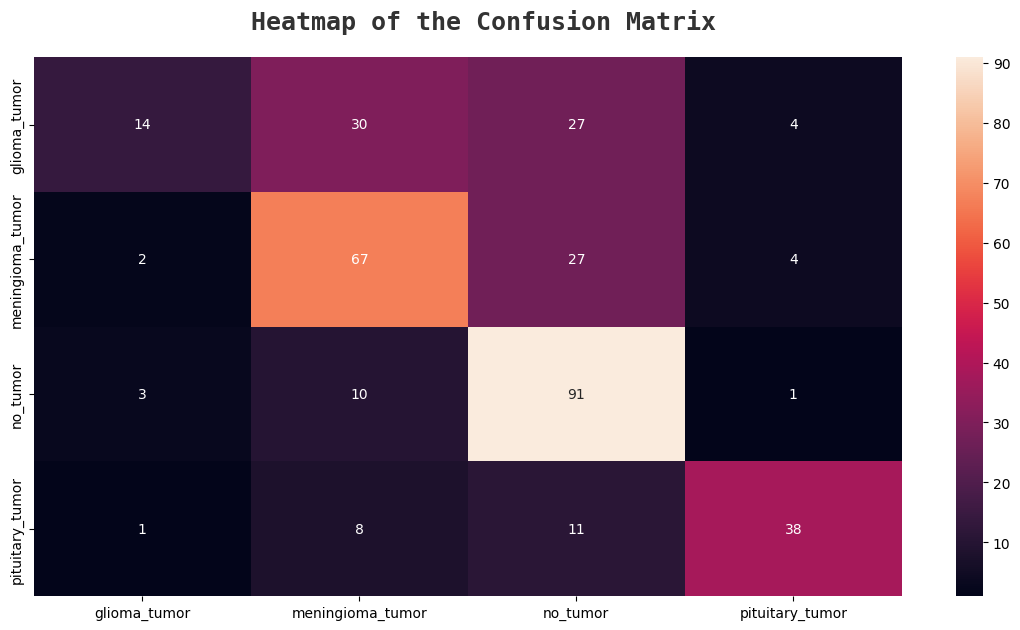

In [ ]:
fig,ax=plt.subplots(1,1,figsize=(14,7))
sns.heatmap(confusion_matrix(y_test_new,pred),ax=ax,xticklabels=labels,yticklabels=labels,annot=True)
fig.text(s='Heatmap of the Confusion Matrix',size=18,fontweight='bold',
             fontname='monospace',y=0.92,x=0.28,alpha=0.8)

plt.show()

In [ ]:
EfficientNetB0

In [ ]:
effnet = EfficientNetB0(weights='imagenet',include_top=False,input_shape=(image_size,image_size,3))

In [ ]:
model_eff = effnet.output
model_eff = tf.keras.layers.GlobalAveragePooling2D()(model_eff)
model_eff = tf.keras.layers.Dropout(rate=0.5)(model_eff)
model_eff = tf.keras.layers.Dense(100,activation='relu')(model_eff)
model_eff = tf.keras.layers.Dense(4,activation='softmax')(model_eff)
model_eff = tf.keras.models.Model(inputs=effnet.input, outputs = model_eff)
model_eff.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_6 (Rescaling)        (None, 224, 224, 3)  0           ['input_5[0][0]']                
                                                                                                  
 normalization_3 (Normalization  (None, 224, 224, 3)  7          ['rescaling_6[0][0]']            
 )                                                                                                
                                                                                            

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model_eff, to_file='model_eff_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
model_eff.compile(loss='categorical_crossentropy',optimizer = 'Adam', metrics= ['accuracy'])

In [ ]:
history = model_eff.fit(X_train, y_train,validation_split=0.2, verbose=1, batch_size = 32, validation_data = (X_val, y_val),
                     epochs = 15)
#, callbacks =[tensorboard,checkpoint,reduce_lr])

Epoch 1/15
28/28 [==============================] - 59s 362ms/step - loss: 0.5537 - accuracy: 0.7831 - val_loss: 1.5699 - val_accuracy: 0.1633
Epoch 2/15
28/28 [==============================] - 8s 272ms/step - loss: 0.1491 - accuracy: 0.9452 - val_loss: 1.6372 - val_accuracy: 0.3673
Epoch 3/15
28/28 [==============================] - 8s 274ms/step - loss: 0.1140 - accuracy: 0.9623 - val_loss: 1.6442 - val_accuracy: 0.3673
Epoch 4/15
28/28 [==============================] - 8s 268ms/step - loss: 0.1300 - accuracy: 0.9600 - val_loss: 1.8007 - val_accuracy: 0.3673
Epoch 5/15
28/28 [==============================] - 8s 276ms/step - loss: 0.0574 - accuracy: 0.9829 - val_loss: 1.8076 - val_accuracy: 0.3673
Epoch 6/15
28/28 [==============================] - 7s 265ms/step - loss: 0.1262 - accuracy: 0.9532 - val_loss: 2.8922 - val_accuracy: 0.3673
Epoch 7/15
28/28 [==============================] - 7s 268ms/step - loss: 0.0875 - accuracy: 0.9680 - val_loss: 1.8942 - val_accuracy: 0.3673
Epoch

In [ ]:
model_eff.save('effB0_model.h5')


acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

TypeError: ignored

In [ ]:
pred = model_eff.predict(X_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)

In [ ]:
accuracy = np.sum(pred==y_test_new)/len(pred)
print("Accuracy on testing dataset: {:.2f}%".format(accuracy*100))

In [ ]:
model_eff.evaluate(X_train, y_train)

28/28 [==============================] - 3s 88ms/step - loss: 1.7481 - accuracy: 0.2945


[1.7481389045715332, 0.2945205569267273]

In [ ]:
print(classification_report(y_test_new,pred))

              precision    recall  f1-score   support

           0       0.70      0.19      0.29        75
           1       0.58      0.67      0.62       100
           2       0.58      0.87      0.70       105
           3       0.81      0.66      0.72        58

    accuracy                           0.62       338
   macro avg       0.67      0.59      0.58       338
weighted avg       0.65      0.62      0.59       338



Text(0.28, 0.92, 'Heatmap of the Confusion Matrix')

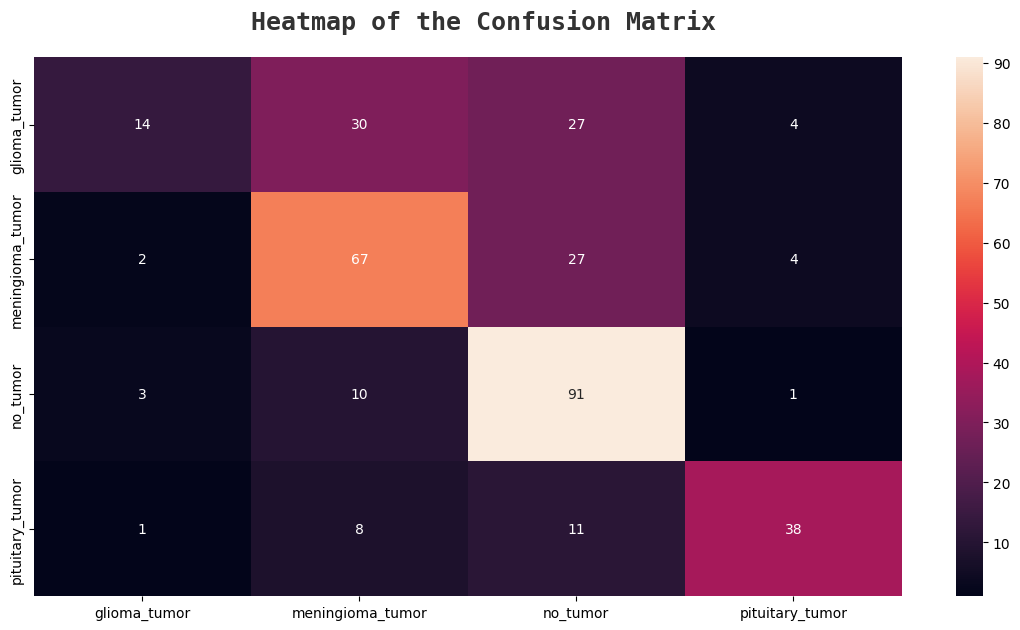

In [ ]:
fig,ax=plt.subplots(1,1,figsize=(14,7))
sns.heatmap(confusion_matrix(y_test_new,pred),ax=ax,xticklabels=labels,yticklabels=labels,annot=True)
fig.text(s='Heatmap of the Confusion Matrix',size=18,fontweight='bold',
             fontname='monospace',y=0.92,x=0.28,alpha=0.8)

In [ ]:
model_cnn = Sequential()

model_cnn.add(Conv2D(64, (5, 5), padding='same',input_shape=(image_size,image_size,3)))
model_cnn.add(Activation('relu'))
#model_cnn.add(BatchNormalization())

model_cnn.add(Conv2D(64, (3, 3), padding='same',input_shape=(image_size,image_size,3)))
model_cnn.add(Activation('relu'))

model_cnn.add(Conv2D(128, (3, 3)))
model_cnn.add(Activation('relu'))
model_cnn.add(MaxPooling2D(pool_size=(2, 2)))
#model_cnn.add(BatchNormalization())
#model_cnn.add(Dropout(0.35))

model_cnn.add(Conv2D(64, (3, 3), padding='same'))
model_cnn.add(Activation('relu'))
model_cnn.add(BatchNormalization())

model_cnn.add(Conv2D(64, (3, 3)))
model_cnn.add(Activation('relu'))
model_cnn.add(MaxPooling2D(pool_size=(2, 2)))
#model_cnn.add(BatchNormalization())
#model_cnn.add(Dropout(0.35))

model_cnn.add(Conv2D(64, (3, 3)))
model_cnn.add(Activation('relu'))
model_cnn.add(MaxPooling2D(pool_size=(2, 2)))

model_cnn.add(Conv2D(64, (3, 3), padding='same'))
model_cnn.add(Activation('relu'))
model_cnn.add(BatchNormalization())

model_cnn.add(Flatten())
model_cnn.add(Dropout(0.5))
model_cnn.add(Dense(512))
model_cnn.add(Activation('relu'))
#model_cnn.add(BatchNormalization())
model_cnn.add(Dense(4))
model_cnn.add(Activation('softmax'))

model_cnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 224, 224, 64)      4864      
                                                                 
 activation_9 (Activation)   (None, 224, 224, 64)      0         
                                                                 
 conv2d_8 (Conv2D)           (None, 224, 224, 64)      36928     
                                                                 
 activation_10 (Activation)  (None, 224, 224, 64)      0         
                                                                 
 conv2d_9 (Conv2D)           (None, 222, 222, 128)     73856     
                                                                 
 activation_11 (Activation)  (None, 222, 222, 128)     0         
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 111, 111, 128)   

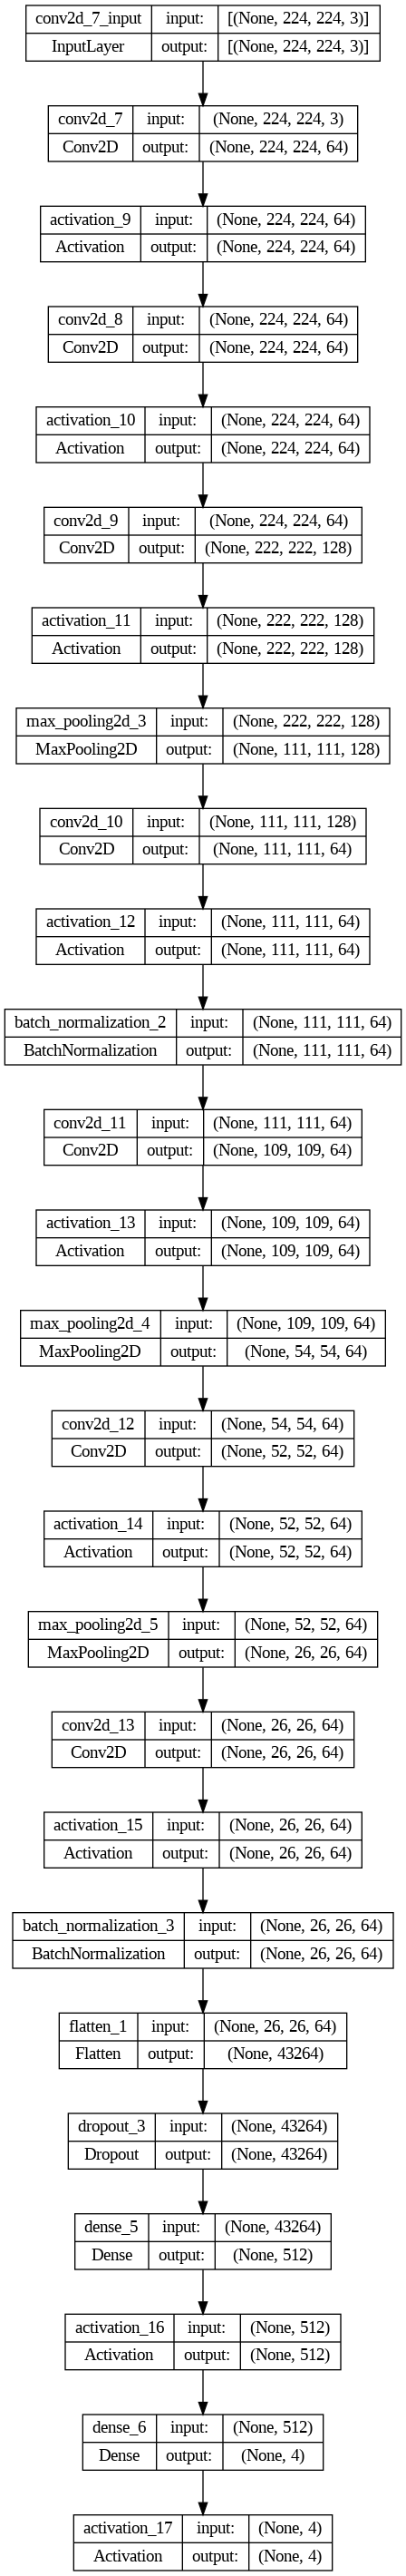

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model_cnn, to_file='model_cnn_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
model_cnn.compile(optimizer = 'adam',
               loss = 'categorical_crossentropy',
               metrics = ['accuracy'])

In [ ]:
history = model_cnn.fit(X_train, y_train,validation_split=0.2, verbose=1, batch_size = 32, validation_data = (X_val, y_val),
                     epochs = 15)

Epoch 1/15
28/28 [==============================] - 26s 557ms/step - loss: 3.3424 - accuracy: 0.5719 - val_loss: 14.6597 - val_accuracy: 0.3367
Epoch 2/15
28/28 [==============================] - 11s 390ms/step - loss: 0.5491 - accuracy: 0.8128 - val_loss: 2.7524 - val_accuracy: 0.3061
Epoch 3/15
28/28 [==============================] - 11s 397ms/step - loss: 0.2390 - accuracy: 0.9189 - val_loss: 0.9124 - val_accuracy: 0.5918
Epoch 4/15
28/28 [==============================] - 11s 379ms/step - loss: 0.1604 - accuracy: 0.9372 - val_loss: 1.0040 - val_accuracy: 0.5714
Epoch 5/15
28/28 [==============================] - 11s 394ms/step - loss: 0.1550 - accuracy: 0.9555 - val_loss: 0.7891 - val_accuracy: 0.6224
Epoch 6/15
28/28 [==============================] - 11s 386ms/step - loss: 0.1016 - accuracy: 0.9669 - val_loss: 0.7576 - val_accuracy: 0.6531
Epoch 7/15
28/28 [==============================] - 10s 375ms/step - loss: 0.0560 - accuracy: 0.9840 - val_loss: 0.4616 - val_accuracy: 0.826

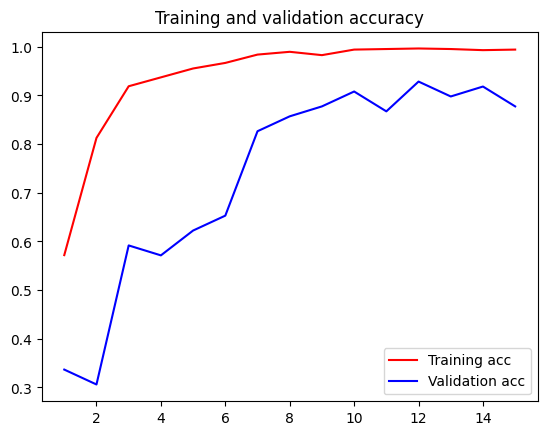

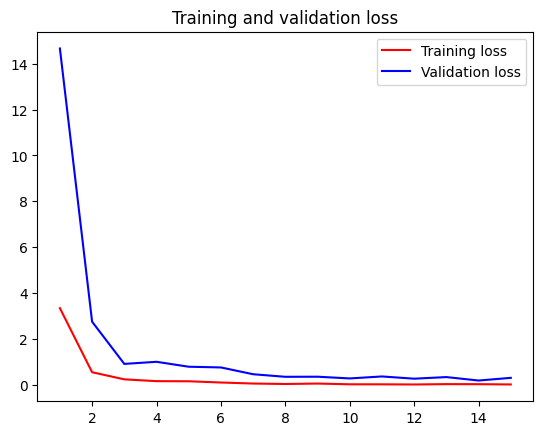

In [ ]:
model_cnn.save('cnn_model.h5')

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
pred = model_cnn.predict(X_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)

11/11 [==============================] - 2s 169ms/step


In [ ]:
accuracy = np.sum(pred==y_test_new)/len(pred)
print("Accuracy on testing dataset: {:.2f}%".format(accuracy*100))

Accuracy on testing dataset: 73.67%


In [ ]:
model_cnn.evaluate(X_train, y_train)

28/28 [==============================] - 3s 103ms/step - loss: 0.0237 - accuracy: 0.9920


[0.02372688800096512, 0.9920091032981873]

In [ ]:
print(classification_report(y_test_new,pred))

              precision    recall  f1-score   support

           0       0.89      0.23      0.36        75
           1       0.84      0.90      0.87       100
           2       0.63      0.98      0.77       105
           3       0.80      0.67      0.73        58

    accuracy                           0.74       338
   macro avg       0.79      0.70      0.68       338
weighted avg       0.78      0.74      0.70       338



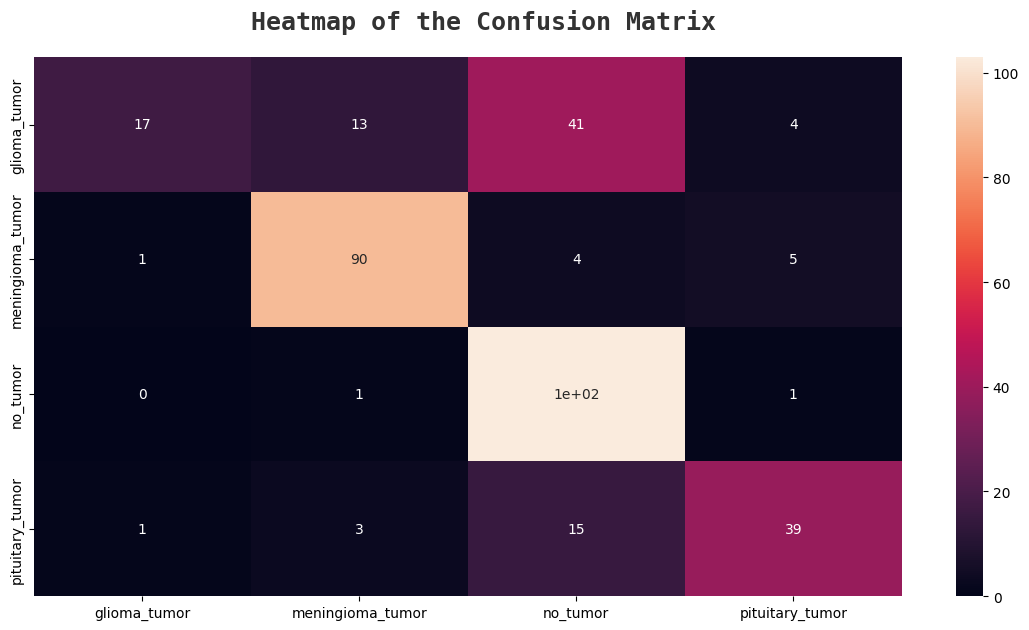

In [ ]:
fig,ax=plt.subplots(1,1,figsize=(14,7))
sns.heatmap(confusion_matrix(y_test_new,pred),ax=ax,xticklabels=labels,yticklabels=labels,annot=True)
fig.text(s='Heatmap of the Confusion Matrix',size=18,fontweight='bold',
             fontname='monospace',y=0.92,x=0.28,alpha=0.8)

plt.show()